# IMPORT LIBRARIES

In [83]:
import pandas as pd
import numpy as np  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency



# LOAD DATASET

In [84]:
df = pd.read_csv("dataset_datasci.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                588 non-null    int64  
 1   date              588 non-null    object 
 2   timestamp         588 non-null    object 
 3   music genre       588 non-null    object 
 4   activity          588 non-null    object 
 5   mood before       588 non-null    int64  
 6   mood after        588 non-null    int64  
 7   sleep             586 non-null    float64
 8   notes (optional)  178 non-null    object 
dtypes: float64(1), int64(3), object(5)
memory usage: 41.5+ KB


# DATA CLEANING

In [85]:
df.head()

,id,date,timestamp,music genre,activity,mood before,mood after,sleep,notes (optional)
0,1,03/12/2025,17:30:00,Hip-Hop/Rap,Read,2,4,9.5,NaN
1,2,03/12/2025,17:30:00,Pop,Read,2,4,9.5,NaN
2,3,03/12/2025,17:30:00,Rock,Read,2,4,9.5,NaN
3,4,03/12/2025,17:30:00,OPM,Read,2,4,9.5,NaN
4,5,03/12/2025,20:32:00,Pop,Rest,3,3,9.5,NaN


In [86]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

<ipython-input-86-626dc0dab295>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


In [87]:
df.isna().sum()

id                    0
date                307
timestamp             0
music genre           0
activity              0
mood before           0
mood after            0
sleep                 2
notes (optional)    410
dtype: int64

In [88]:
# drop uninmportant columns
df = df.drop(columns=['notes (optional)'])

In [89]:
# check the rows with missing sleep values

df[df['sleep'].isna()] 

,id,date,timestamp,music genre,activity,mood before,mood after,sleep
320,321,2026-09-01,2026-02-11 14:24:00,OPM,Commute,3,3,NaN
321,322,2026-09-01,2026-02-11 15:05:00,EDM,Walk,3,4,NaN


In [90]:
# fill missing date with timestamp date accordingly to their row 

df['date'] = df['date'].fillna(df['timestamp'].dt.date)

In [91]:
# fill missing values of sleep with median

df['sleep'].fillna(df['sleep'].median(), inplace=True)

<ipython-input-91-ecde9955426f>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sleep'].fillna(df['sleep'].median(), inplace=True)


In [92]:
df.isna().sum()

id             0
date           0
timestamp      0
music genre    0
activity       0
mood before    0
mood after     0
sleep          0
dtype: int64

# PRE-PROCESSING

In [93]:
# GROUPING MUSIC GENRES

genre_mapping = {
    # Mainstream group
    'Pop': 'Mainstream', 
    'R&B': 'Mainstream', 
    'R&b': 'Mainstream',
    'OPM': 'Mainstream',


    # High-Energy group
    'Rock': 'High-Energy', 
    'Hard Rock': 'High-Energy', 
    'Pop-Rock': 'High-Energy', 
    'Pop Rock': 'High-Energy', 
    'Pop- Rock': 'High-Energy',
    'Rap-Rock': 'High-Energy',
    'EDM': 'High-Energy',
    'Rap': 'High-Energy', 
    'Hip-Hop/Soul': 'Mainstream',
    'Hip-Hop': 'High-Energy', 
    'Hip-Hop/Rap': 'High-Energy',
    
    # Low-Energy group
    'Indie': 'Low-Energy',
    'Soft Pop': 'Low-Energy', 
    'Indie Pop': 'Low-Energy', 
    'Slow Pop': 'Low-Energy', 
    
}

df['music genre'] = df['music genre'].map(genre_mapping)

In [94]:
# GROUPING THE DAILY ACTIVITIES

activity_mapping = {
    'Rest': 'Relax', 
    'Play': 'Relax', 
    
    'Read': 'Focus',
    'Work': 'Focus', 
    'Code': 'Focus',
    
    'Clean': 'Routine',
    'Shower': 'Routine', 
    'Prepare': 'Routine',
    'Commute': 'Routine', 
    
    'Exercise': 'Active',
    'Walk': 'Active',
}

df['activity'] = df['activity'].map(activity_mapping)

In [95]:
df.head()

,id,date,timestamp,music genre,activity,mood before,mood after,sleep
0,1,2025-03-12,2026-02-11 17:30:00,High-Energy,Focus,2,4,9.5
1,2,2025-03-12,2026-02-11 17:30:00,Mainstream,Focus,2,4,9.5
2,3,2025-03-12,2026-02-11 17:30:00,High-Energy,Focus,2,4,9.5
3,4,2025-03-12,2026-02-11 17:30:00,Mainstream,Focus,2,4,9.5
4,5,2025-03-12,2026-02-11 20:32:00,Mainstream,Relax,3,3,9.5


# DESCRIPTIVE STATISTICS

MEAN, MEDIAN, MODE, SD

In [96]:
df_statistics = df[['mood before', 'mood after', 'sleep']].agg(['mean', 'median', 'std']).round(2)
df_statistics

,mood before,mood after,sleep
mean,2.79,3.37,6.68
median,3.00,3.00,7.00
std,1.06,0.99,1.68


# EDA

## grouped bar

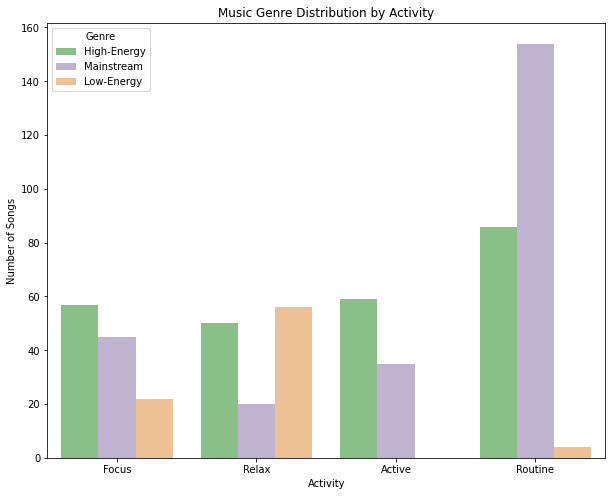

In [161]:
plt.figure(figsize=(10, 8))
sns.countplot(x='activity', hue='music genre', data=df, palette='Accent')
plt.title('Music Genre Distribution by Activity')
plt.xlabel('Activity')
plt.ylabel('Number of Songs')
plt.legend(title='Genre')
plt.show()

## stacked bar activities

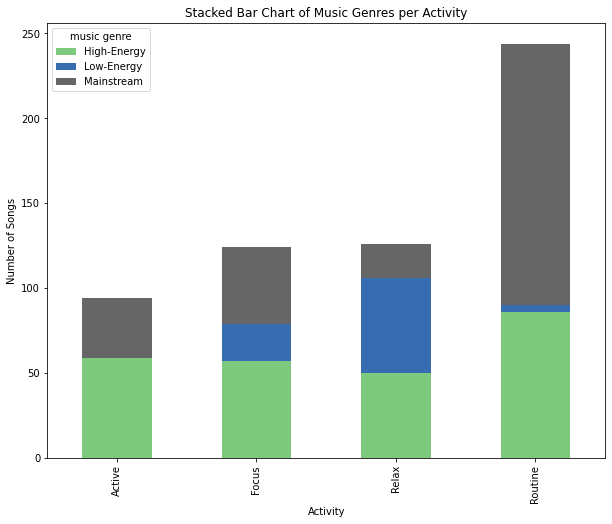

In [162]:
genre_activity = pd.crosstab(df['activity'], df['music genre'])
genre_activity.plot(kind='bar', stacked=True, colormap='Accent', figsize=(10, 8))
plt.title('Stacked Bar Chart of Music Genres per Activity')
plt.xlabel('Activity')
plt.ylabel('Number of Songs')
plt.show()

## histograms for mood and sleep

Text(0, 0.5, 'Frequency')

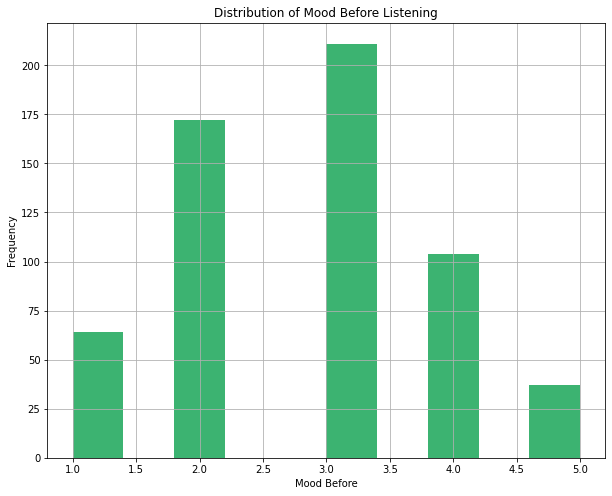

In [134]:
# histogram of mood before

plt.figure(figsize=(10, 8))

df['mood before'].hist(bins=10, color='mediumseagreen')
plt.title('Distribution of Mood Before Listening')
plt.xlabel('Mood Before')
plt.ylabel('Frequency')

Text(0.5, 0, 'Mood After')

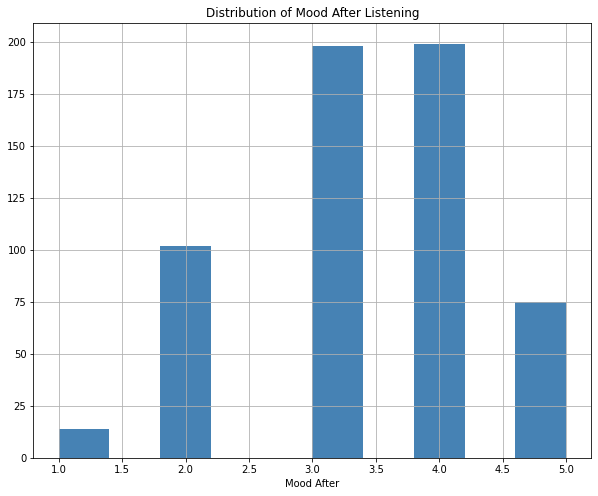

In [166]:
# histogram of mood after

plt.figure(figsize=(10, 8))
df['mood after'].hist(bins=10, color='steelblue')
plt.title('Distribution of Mood After Listening')
plt.xlabel('Mood After')

Text(0.5, 0, 'Sleep (hours)')

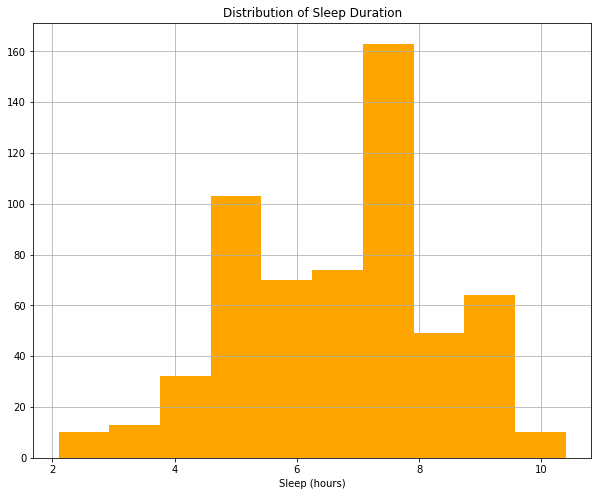

In [169]:
# histogram of sleep duration

plt.figure(figsize=(10, 8))
df['sleep'].hist(bins=10, color='orange')
plt.title('Distribution of Sleep Duration')
plt.xlabel('Sleep (hours)')

## time series

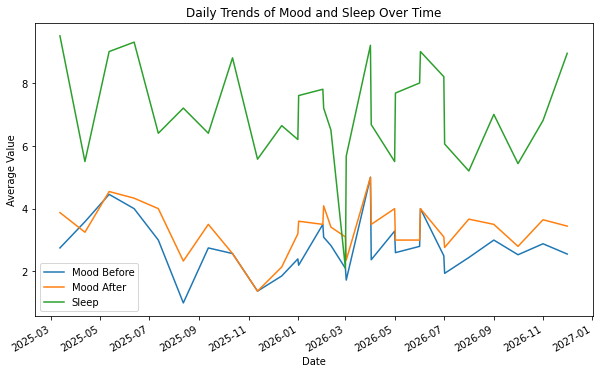

In [102]:
# Daily averages
daily_trends = df.groupby('date')[['mood before', 'mood after', 'sleep']].mean()

daily_trends.plot(figsize=(10, 6))
plt.title('Daily Trends of Mood and Sleep Over Time')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.legend(['Mood Before', 'Mood After', 'Sleep'])
plt.show()


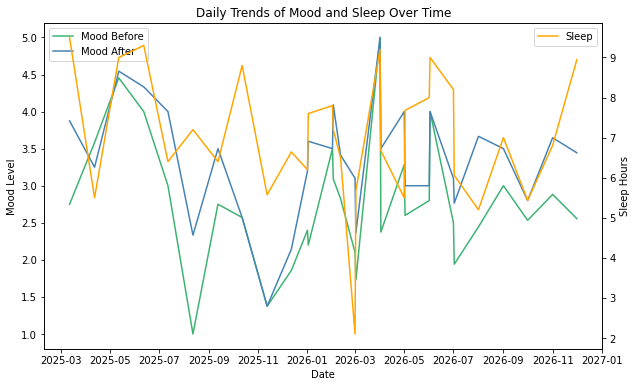

In [170]:
# time series with two y axis
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(daily_trends.index, daily_trends['mood before'], color='mediumseagreen', label='Mood Before')
ax1.plot(daily_trends.index, daily_trends['mood after'], color='steelblue', label='Mood After')
ax1.set_xlabel('Date')
ax1.set_ylabel('Mood Level')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # create a second y-axis
ax2.plot(daily_trends.index, daily_trends['sleep'], color='orange', label='Sleep')
ax2.set_ylabel('Sleep Hours')
ax2.legend(loc='upper right')

plt.title('Daily Trends of Mood and Sleep Over Time')
plt.show()


# STATISTICAL TESTS

## ANOVA mood before and music genre

In [104]:
from scipy.stats import f_oneway

groups = [
    df[df['music genre'] == g]['mood before']
    for g in df['music genre'].dropna().unique()
]

anova_mood_before = f_oneway(*groups)
anova_mood_before


F_onewayResult(statistic=3.8706758587599004, pvalue=0.02138021974200927)

## ANOVA mood after and music genre

In [105]:
groups_after = [
    df[df['music genre'] == g]['mood after']
    for g in df['music genre'].dropna().unique()
]

anova_mood_after = f_oneway(*groups_after)
anova_mood_after


F_onewayResult(statistic=6.473677830565454, pvalue=0.0016564489852976913)

## ANOVA sleep duration and music genre

In [106]:
groups_sleep = [
    df[df['music genre'] == g]['sleep']
    for g in df['music genre'].dropna().unique()
]

anova_sleep = f_oneway(*groups_sleep)
anova_sleep


F_onewayResult(statistic=2.987395789184382, pvalue=0.051188352625783924)

## chi-square activities and music genre

In [107]:
observed = pd.crosstab(df['activity'], df['music genre'])
print(observed)

music genre  High-Energy  Low-Energy  Mainstream
activity                                        
Active                59           0          35
Focus                 57          22          45
Relax                 50          56          20
Routine               86           4         154


In [108]:
# Create contingency table
contingency_table = pd.crosstab(df['activity'], df['music genre'])

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

chi2, p, dof


(183.82754720616836, 5.218381417047719e-37, 6)

In [109]:
expected_df = pd.DataFrame(
    expected,
    index=contingency_table.index,
    columns=contingency_table.columns
)
expected_df


music genre,High-Energy,Low-Energy,Mainstream
activity,,,
Active,40.285714,13.108844,40.605442
Focus,53.142857,17.292517,53.564626
Relax,54.000000,17.571429,54.428571
Routine,104.571429,34.027211,105.401361


## correlation matrix

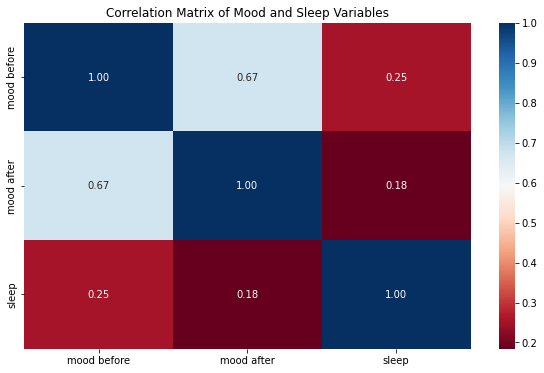

In [152]:
# Correlation matrix
corr_matrix = df[['mood before', 'mood after', 'sleep']].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt=".2f")
plt.title('Correlation Matrix of Mood and Sleep Variables')
plt.show()


# RANDOM FOREST ML MODEL 

In [111]:
df_rf = df.copy()

In [112]:
df_rf.head()

,id,date,timestamp,music genre,activity,mood before,mood after,sleep
0,1,2025-03-12,2026-02-11 17:30:00,High-Energy,Focus,2,4,9.5
1,2,2025-03-12,2026-02-11 17:30:00,Mainstream,Focus,2,4,9.5
2,3,2025-03-12,2026-02-11 17:30:00,High-Energy,Focus,2,4,9.5
3,4,2025-03-12,2026-02-11 17:30:00,Mainstream,Focus,2,4,9.5
4,5,2025-03-12,2026-02-11 20:32:00,Mainstream,Relax,3,3,9.5


In [113]:
df_rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           588 non-null    int64         
 1   date         588 non-null    datetime64[ns]
 2   timestamp    588 non-null    datetime64[ns]
 3   music genre  588 non-null    object        
 4   activity     588 non-null    object        
 5   mood before  588 non-null    int64         
 6   mood after   588 non-null    int64         
 7   sleep        588 non-null    float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 36.9+ KB


In [114]:
df_rf.isna().sum()

id             0
date           0
timestamp      0
music genre    0
activity       0
mood before    0
mood after     0
sleep          0
dtype: int64

## preprocessing

In [115]:
# FEATURE SELECTION AND TARGET DEFINITION FOR MODEL
X = df_rf[['activity', 'mood before', 'mood after', 'sleep']]
y = df_rf['music genre']

In [116]:
# DEFINE CATEGORICAL AND NUMERICAL VALUES (CONFIGURATION)

categorical_cols = ['activity']
numerical_cols = ['mood before', 'mood after', 'sleep']

In [117]:
# BUILDING MODEL PIPELINE (RANDOM FOREST)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['activity']),
        ('num', 'passthrough', ['mood before', 'mood after', 'sleep'])
    ]
)

rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')

pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', rf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

## train test split

In [118]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [119]:
# TRAIN THE MODEL
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['activity']),
                                                 ('num', 'passthrough',
                                                  ['mood before', 'mood after',
                                                   'sleep'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

## evaluate

In [120]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

 High-Energy       0.62      0.56      0.59        54
  Low-Energy       0.73      0.38      0.50        21
  Mainstream       0.54      0.74      0.63        43

    accuracy                           0.59       118
   macro avg       0.63      0.56      0.57       118
weighted avg       0.61      0.59      0.59       118

[[30  1 23]
 [ 9  8  4]
 [ 9  2 32]]


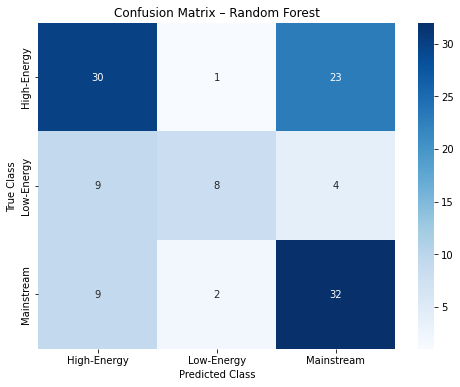

In [121]:
# confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
labels = ['High-Energy', 'Low-Energy', 'Mainstream']

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix – Random Forest')
plt.show()

In [122]:
print("RANDOM FOREST ALL FACTORS")
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy: {:.2f}".format(np.mean(cv_scores)))

RANDOM FOREST ALL FACTORS
Cross-Validation Accuracy Scores: [0.72033898 0.61864407 0.58474576 0.56410256 0.57264957]
Mean CV Accuracy: 0.61


## feature importance

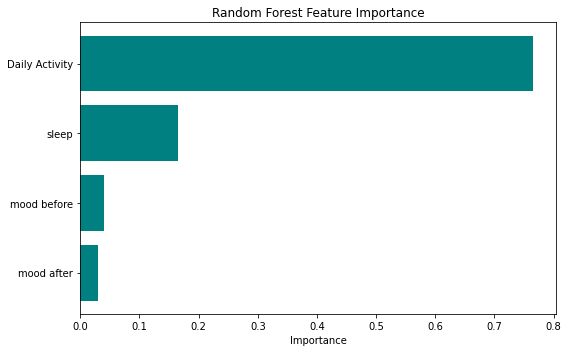

In [171]:
# Get feature names after OneHotEncoder + numerical
cat_features = pipeline.named_steps['preprocess'].named_transformers_['cat'].get_feature_names_out(['activity'])
num_features = ['mood before', 'mood after', 'sleep']
all_features = np.concatenate([num_features, cat_features])

# Extract feature importances
rf_model = pipeline.named_steps['model']
importances = rf_model.feature_importances_

feat_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
})

# Combine all one-hot activity features into a single 'Daily Activity'
activity_mask = feat_importance_df['Feature'].str.startswith('activity')
activity_importance = feat_importance_df.loc[activity_mask, 'Importance'].sum()

# Keep only non-activity features and combined activity
combined_df = feat_importance_df.loc[~activity_mask].copy()
combined_df = pd.concat([combined_df, pd.DataFrame({'Feature': ['Daily Activity'], 'Importance': [activity_importance]})])

# Sort
combined_df = combined_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
plt.barh(combined_df['Feature'], combined_df['Importance'], color='teal')
plt.gca().invert_yaxis()  # highest importance on top
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()
